# MNIST Data Image Recognition

In this notebook we propose a simple Neural Network (NN) architecture to recognize hand-written digits. We use the MNIST dataset, consisting of 70,000 images split into 60,000 for training and 10,000 for validation.

While image recognition tasks are more efficiently handled by Convolutional Neural Networks (CNNs), this notebook focuses on a fully connected neural network (FCNN), leaving the CNN as an aside project. This enables us, firstly to assess the importance of hyperparameter tuning in FCNNs involving simple data and, secondly, to better appreciate the power of CNNs for image recognition tasks, by comparing the performance of the two architectures.

Following the literature on this task, we begin with a simple benchmark architecture, consisting of one hidden-layer with 128 nodes, a ReLU activation function, and an output softmax activation function for the output layer, combined with a cross-validation entropy loss-function, the standard choice for non-binary classification. Moreover, we opt for an ADAM optimizer with default 0.001 learning rate, and 32-sized mini-batches. We compute the loss function and accuracy on both the training and validation sets to assess the efficiency of the NN.

We then perform a hyperparameter search over various hyperparameters, evaluating the error on the validation set for each combination of hyperparameters and we select the most accurate ones. Considering the simplicity of the images involved we opt to stick with having just one hidden layer, and vary the other hyperparameters as follows:

- learning rates = 0.0001, 0.001, 0.01
- batch sizes = 32, 64, 128
- epochs = 10, 20, 50
- hidden units = 64, 128, 256
- activations = relu, tanh
- optimizers = adam, sgd, rmsprop

We train and test all 486 combinations of these hyperparameters and select the 5 combinations which yield the best accuracy on the validation set.

In [2]:
#import libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
import time

In [3]:
# Load MNIST dataset from tf and reshape

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Print dataset statistics
print(f"Number of training images: {train_images.shape[0]}")
print(f"Image dimensions: {train_images.shape[1]}x{train_images.shape[2]}")
print(f"First label: {train_labels[0]} \n ")

# Normalize the image data RGB
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

#Print shape of train and test images, before and after reshaping
print(f"Dimension of array of training images: {train_images.shape}")
print(f"Dimension of array of training labels: {train_labels.shape}")
print(f"So, our training set has {train_images.shape[0]} examples, with {train_images.shape[1]}x{train_images.shape[2]} pixels per example")
print(f"Flattening out the image from a {train_images.shape[1]}x{train_images.shape[2]} array to a {train_images.shape[1]*train_images.shape[2]}-dimensional vector")


# Flatten each 28x28 image into a vector of size 784 (28*28)
x_train = train_images.reshape(-1, train_images.shape[1] * train_images.shape[2])
x_test = test_images.reshape(-1, test_images.shape[1] * test_images.shape[2])

y_train = train_labels
y_test = test_labels


# Print the new shape to verify
print(f"\nFlattened training images shape: {x_train.shape}")
print(f"Flattened test images shape: {x_test.shape}")

print(f"\nTraining images labels shape: {y_train.shape}")
print(f"Test images labels shape: {y_test.shape}")

Number of training images: 60000
Image dimensions: 28x28
First label: 5 
 
Dimension of array of training images: (60000, 28, 28)
Dimension of array of training labels: (60000,)
So, our training set has 60000 examples, with 28x28 pixels per example
Flattening out the image from a 28x28 array to a 784-dimensional vector

Flattened training images shape: (60000, 784)
Flattened test images shape: (10000, 784)

Training images labels shape: (60000,)
Test images labels shape: (10000,)


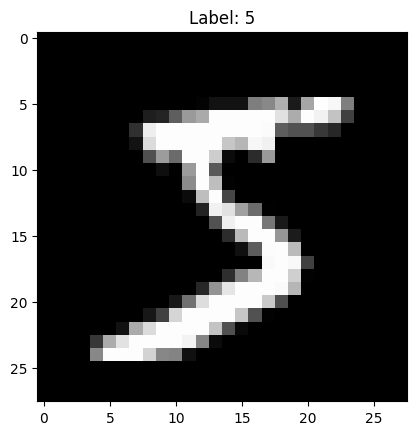

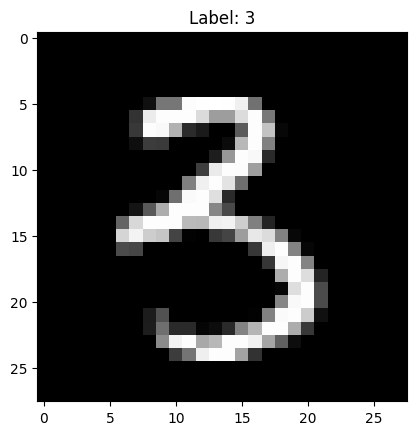

In [4]:
#test plotting  loaded images
plt.imshow(train_images[0], cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.show()


plt.imshow(test_images[5000], cmap='gray')
plt.title(f"Label: {test_labels[5000]}")
plt.show()

We begin with a benchmark NN with the following details:
- one hidden layer, 128 nodes, ReLU activation function
- output layer, 10 nodes, softmax activation function, cross-entropy loss function
- ADAM optimizer, 0.001 learning rate (default)
- 32-sized mini-batches (default)
- 10 training epochs

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8751 - loss: 0.4353 - val_accuracy: 0.9560 - val_loss: 0.1516
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9637 - loss: 0.1241 - val_accuracy: 0.9682 - val_loss: 0.1045
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9761 - loss: 0.0809 - val_accuracy: 0.9726 - val_loss: 0.0864
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9830 - loss: 0.0577 - val_accuracy: 0.9769 - val_loss: 0.0804
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9866 - loss: 0.0444 - val_accuracy: 0.9743 - val_loss: 0.0823
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9898 - loss: 0.0335 - val_accuracy: 0.9779 - val_loss: 0.0762
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9927 - loss: 0.0257 - val_accuracy: 0.9773 - val_loss: 0.0754
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9931 - loss: 0.0217 - 

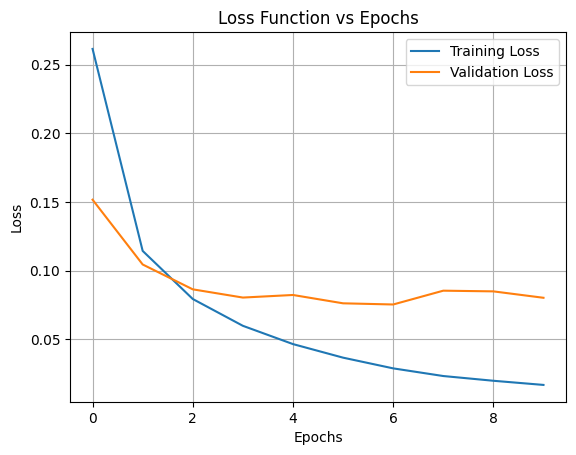

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9731 - loss: 0.0950
Final training accuracy: 0.9949
Final dev accuracy: 0.9782

Final training error: 0.5133330821990967 %
Final dev error: 2.1799981594085693 %


In [13]:
#Benchmark Neural Network (without regularization)

#number of nodes in hidden and output layers
n1 = 128
nout = 10

model = models.Sequential([
    layers.Dense(n1, activation='relu', input_shape=(28*28,)),
    layers.Dense(nout, activation='softmax')
])


model.summary()


# Compile the model with ADAM
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model and save the training history
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Plot the loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function vs Epochs')
plt.legend()
plt.grid()
plt.show()

#Evaluate the model
model.evaluate(x_test, y_test)

training_error = (1 - history.history['accuracy'][-1])
dev_error = (1 - history.history['val_accuracy'][-1])

print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final dev accuracy: {history.history['val_accuracy'][-1]:.4f}")

print(f"\nFinal training error: {training_error*100} %")
print(f"Final dev error: {dev_error*100} %")


We find the following performance for the benchmark NN:
- Final training error: 0.49 %
- Final dev error: 2.37 %
The variance amounts to 1.88%. This can be anticipated by considering the plots of the loss function vs epochs for the training set, which decreases steadily, and for the validation set, which plateaus after ~4 epochs. This could be due to overfitting. We will address this later by employing regularization. 

We now explore the model more thoroughly by performing a systematic search of hyperparameters over a grid.

In [6]:
# Hyperparameter grid
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [32, 64, 128]
epochs = [10, 20, 50]
hidden_units = [64, 128, 256]
activations = ['relu', 'tanh']
optimizers = ['adam', 'sgd', 'rmsprop']

# Function to create and compile model
def create_model(learning_rate, batch_size, hidden_units, activation, optimizer):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hidden_units, activation=activation, input_shape=(28*28,)),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    # Compile model with given optimizer and learning rate
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# List to store results
results = []

# Grid search
for lr, batch, epoch, units, activation, optimizer in itertools.product(
    learning_rates, batch_sizes, epochs, hidden_units, activations, optimizers):
    
    print(f"Training with lr={lr}, batch_size={batch}, epochs={epoch}, units={units}, activation={activation}, optimizer={optimizer}")
    
    model = create_model(lr, batch, units, activation, optimizer)
    
    # Train the model
    history = model.fit(x_train, y_train, 
                        epochs=epoch, 
                        batch_size=batch, 
                        validation_data=(x_test, y_test), 
                        verbose=0)
    
    # Evaluate model performance
    val_accuracy = history.history['val_accuracy'][-1]
    
    # Calculate dev error (1 - validation accuracy)
    dev_error = 1 - val_accuracy
    
    # Append results
    results.append({
        'learning_rate': lr,
        'batch_size': batch,
        'epochs': epoch,
        'hidden_units': units,
        'activation': activation,
        'optimizer': optimizer,
        'val_accuracy': val_accuracy,
        'dev_error': dev_error
    })

# Sort results by validation accuracy in descending order
sorted_results = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)

# Print the top 5 results
print("\nTop 5 hyperparameter choices:")
for i, result in enumerate(sorted_results[:5]):
    print(f"\nRank {i+1}:")
    print(f"Learning rate: {result['learning_rate']}")
    print(f"Batch size: {result['batch_size']}")
    print(f"Epochs: {result['epochs']}")
    print(f"Hidden units: {result['hidden_units']}")
    print(f"Activation: {result['activation']}")
    print(f"Optimizer: {result['optimizer']}")
    print(f"Validation accuracy: {result['val_accuracy']:.4f}")
    print(f"Dev error: {result['dev_error'] * 100:.2f}%")


Training with lr=0.0001, batch_size=32, epochs=10, units=64, activation=relu, optimizer=adam
Training with lr=0.0001, batch_size=32, epochs=10, units=64, activation=relu, optimizer=sgd
Training with lr=0.0001, batch_size=32, epochs=10, units=64, activation=relu, optimizer=rmsprop
Training with lr=0.0001, batch_size=32, epochs=10, units=64, activation=tanh, optimizer=adam
Training with lr=0.0001, batch_size=32, epochs=10, units=64, activation=tanh, optimizer=sgd
Training with lr=0.0001, batch_size=32, epochs=10, units=64, activation=tanh, optimizer=rmsprop
Training with lr=0.0001, batch_size=32, epochs=10, units=128, activation=relu, optimizer=adam
Training with lr=0.0001, batch_size=32, epochs=10, units=128, activation=relu, optimizer=sgd
Training with lr=0.0001, batch_size=32, epochs=10, units=128, activation=relu, optimizer=rmsprop
Training with lr=0.0001, batch_size=32, epochs=10, units=128, activation=tanh, optimizer=adam
Training with lr=0.0001, batch_size=32, epochs=10, units=128

Training with lr=0.0001, batch_size=64, epochs=20, units=256, activation=tanh, optimizer=adam
Training with lr=0.0001, batch_size=64, epochs=20, units=256, activation=tanh, optimizer=sgd
Training with lr=0.0001, batch_size=64, epochs=20, units=256, activation=tanh, optimizer=rmsprop
Training with lr=0.0001, batch_size=64, epochs=50, units=64, activation=relu, optimizer=adam
Training with lr=0.0001, batch_size=64, epochs=50, units=64, activation=relu, optimizer=sgd
Training with lr=0.0001, batch_size=64, epochs=50, units=64, activation=relu, optimizer=rmsprop
Training with lr=0.0001, batch_size=64, epochs=50, units=64, activation=tanh, optimizer=adam
Training with lr=0.0001, batch_size=64, epochs=50, units=64, activation=tanh, optimizer=sgd
Training with lr=0.0001, batch_size=64, epochs=50, units=64, activation=tanh, optimizer=rmsprop
Training with lr=0.0001, batch_size=64, epochs=50, units=128, activation=relu, optimizer=adam
Training with lr=0.0001, batch_size=64, epochs=50, units=128

Training with lr=0.001, batch_size=32, epochs=10, units=256, activation=relu, optimizer=adam
Training with lr=0.001, batch_size=32, epochs=10, units=256, activation=relu, optimizer=sgd
Training with lr=0.001, batch_size=32, epochs=10, units=256, activation=relu, optimizer=rmsprop
Training with lr=0.001, batch_size=32, epochs=10, units=256, activation=tanh, optimizer=adam
Training with lr=0.001, batch_size=32, epochs=10, units=256, activation=tanh, optimizer=sgd
Training with lr=0.001, batch_size=32, epochs=10, units=256, activation=tanh, optimizer=rmsprop
Training with lr=0.001, batch_size=32, epochs=20, units=64, activation=relu, optimizer=adam
Training with lr=0.001, batch_size=32, epochs=20, units=64, activation=relu, optimizer=sgd
Training with lr=0.001, batch_size=32, epochs=20, units=64, activation=relu, optimizer=rmsprop
Training with lr=0.001, batch_size=32, epochs=20, units=64, activation=tanh, optimizer=adam
Training with lr=0.001, batch_size=32, epochs=20, units=64, activati

Training with lr=0.001, batch_size=64, epochs=50, units=128, activation=tanh, optimizer=sgd
Training with lr=0.001, batch_size=64, epochs=50, units=128, activation=tanh, optimizer=rmsprop
Training with lr=0.001, batch_size=64, epochs=50, units=256, activation=relu, optimizer=adam
Training with lr=0.001, batch_size=64, epochs=50, units=256, activation=relu, optimizer=sgd
Training with lr=0.001, batch_size=64, epochs=50, units=256, activation=relu, optimizer=rmsprop
Training with lr=0.001, batch_size=64, epochs=50, units=256, activation=tanh, optimizer=adam
Training with lr=0.001, batch_size=64, epochs=50, units=256, activation=tanh, optimizer=sgd
Training with lr=0.001, batch_size=64, epochs=50, units=256, activation=tanh, optimizer=rmsprop
Training with lr=0.001, batch_size=128, epochs=10, units=64, activation=relu, optimizer=adam
Training with lr=0.001, batch_size=128, epochs=10, units=64, activation=relu, optimizer=sgd
Training with lr=0.001, batch_size=128, epochs=10, units=64, acti

Training with lr=0.01, batch_size=32, epochs=20, units=128, activation=relu, optimizer=rmsprop
Training with lr=0.01, batch_size=32, epochs=20, units=128, activation=tanh, optimizer=adam
Training with lr=0.01, batch_size=32, epochs=20, units=128, activation=tanh, optimizer=sgd
Training with lr=0.01, batch_size=32, epochs=20, units=128, activation=tanh, optimizer=rmsprop
Training with lr=0.01, batch_size=32, epochs=20, units=256, activation=relu, optimizer=adam
Training with lr=0.01, batch_size=32, epochs=20, units=256, activation=relu, optimizer=sgd
Training with lr=0.01, batch_size=32, epochs=20, units=256, activation=relu, optimizer=rmsprop
Training with lr=0.01, batch_size=32, epochs=20, units=256, activation=tanh, optimizer=adam
Training with lr=0.01, batch_size=32, epochs=20, units=256, activation=tanh, optimizer=sgd
Training with lr=0.01, batch_size=32, epochs=20, units=256, activation=tanh, optimizer=rmsprop
Training with lr=0.01, batch_size=32, epochs=50, units=64, activation=r

Training with lr=0.01, batch_size=128, epochs=10, units=128, activation=relu, optimizer=sgd
Training with lr=0.01, batch_size=128, epochs=10, units=128, activation=relu, optimizer=rmsprop
Training with lr=0.01, batch_size=128, epochs=10, units=128, activation=tanh, optimizer=adam
Training with lr=0.01, batch_size=128, epochs=10, units=128, activation=tanh, optimizer=sgd
Training with lr=0.01, batch_size=128, epochs=10, units=128, activation=tanh, optimizer=rmsprop
Training with lr=0.01, batch_size=128, epochs=10, units=256, activation=relu, optimizer=adam
Training with lr=0.01, batch_size=128, epochs=10, units=256, activation=relu, optimizer=sgd
Training with lr=0.01, batch_size=128, epochs=10, units=256, activation=relu, optimizer=rmsprop
Training with lr=0.01, batch_size=128, epochs=10, units=256, activation=tanh, optimizer=adam
Training with lr=0.01, batch_size=128, epochs=10, units=256, activation=tanh, optimizer=sgd
Training with lr=0.01, batch_size=128, epochs=10, units=256, acti

We find the following 5 sets hyperparameter choices which yield the best accuracy:

Rank 1:
Learning rate: 0.0001
Batch size: 32
Epochs: 50
Hidden units: 256
Activation: tanh
Optimizer: rmsprop
Validation accuracy: 0.9841
Dev error: 1.59%

Rank 2:
Learning rate: 0.01
Batch size: 64
Epochs: 50
Hidden units: 256
Activation: relu
Optimizer: rmsprop
Validation accuracy: 0.9840
Dev error: 1.60%

Rank 3:
Learning rate: 0.001
Batch size: 64
Epochs: 50
Hidden units: 256
Activation: tanh
Optimizer: rmsprop
Validation accuracy: 0.9839
Dev error: 1.61%

Rank 4:
Learning rate: 0.01
Batch size: 64
Epochs: 50
Hidden units: 256
Activation: tanh
Optimizer: rmsprop
Validation accuracy: 0.9837
Dev error: 1.63%

Rank 5:
Learning rate: 0.0001
Batch size: 128
Epochs: 50
Hidden units: 256
Activation: relu
Optimizer: rmsprop
Validation accuracy: 0.9836
Dev error: 1.64%

Compred to the previous benchmark scenario, which achieved a dev error = 2.37%, the best set of hyperparameters here yields an improvement of 0.78%.

We now consider the 3 best combinations of hyperparameters and inspect them further.

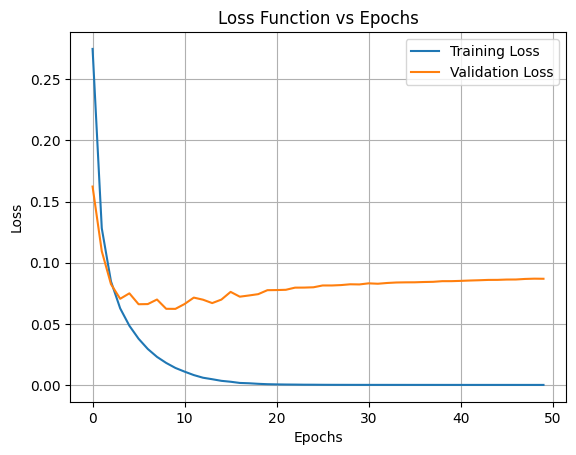

Final training accuracy: 1.0000
Final dev accuracy: 0.9826

Final training error: 0.5133330821990967 %
Final dev error: 1.7400026321411133 %


In [17]:
#Most Accurate Neural Network


#Hyperparameters 'best' (b)
lr_b = 0.0001
batch_b = 32
epoch_b = 50
units_b = 256
activation_b = 'tanh'
optimizer_b = 'rmsprop'

# Function to create and compile model
def create_model(learning_rate, batch_size, hidden_units, activation, optimizer):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hidden_units, activation=activation, input_shape=(28*28,)),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    # Compile model with given optimizer and learning rate
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model


model = create_model(lr_b, batch_b, units_b, activation_b, optimizer_b)

# Train the model
history = model.fit(x_train, y_train, 
                        epochs=epoch_b, 
                        batch_size=batch_b, 
                        validation_data=(x_test, y_test), 
                        verbose=0)


    
# Evaluate model performance
val_accuracy = history.history['val_accuracy'][-1]


# Calculate dev error (1 - validation accuracy)
dev_error = 1 - val_accuracy



# Plot the loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function vs Epochs')
plt.legend()
plt.grid()
plt.show()


print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final dev accuracy: {history.history['val_accuracy'][-1]:.4f}")

print(f"\nFinal training error: {training_error*100} %")
print(f"Final dev error: {dev_error*100} %")

We note that while the loss function on the training set converges extremely well, the loss function on the validation set stops decreasing after around 10 epochs, and slightly increases reaching 50 epochs, for all 3 most accurate models. This suggests an overfitting of the training data, which motivates us to include regularization.

Below we try both L2 and dropout regularization, first separately, then combining them. Again, we begin by considering a benchmark model with fixed L2 lambda parameter and dropout rate, and then scan over possible combinations of them to select the values that work best.


Training with L2 regularization λ = 1e-05


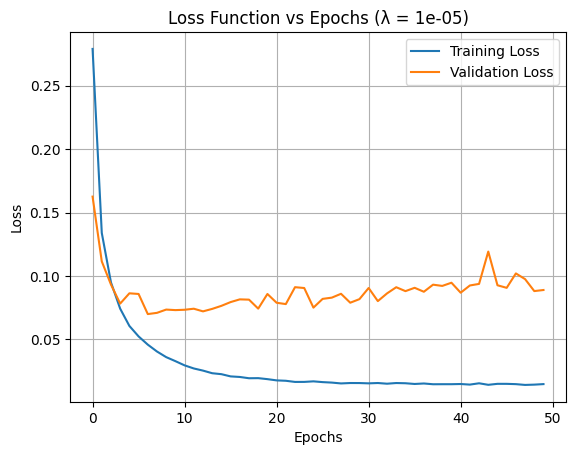

Final dev accuracy: 0.9807
Final dev error: 1.93 %


Training with L2 regularization λ = 0.0001


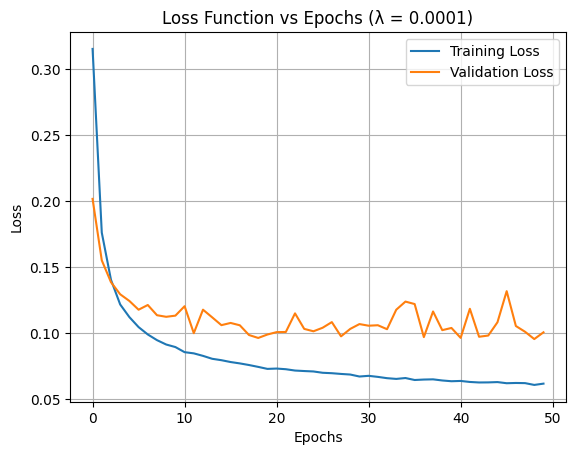

Final dev accuracy: 0.9782
Final dev error: 2.18 %


Training with L2 regularization λ = 0.001


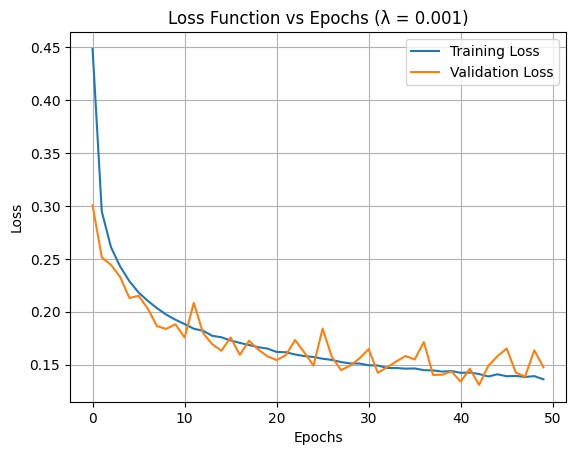

Final dev accuracy: 0.9706
Final dev error: 2.94 %


Training with L2 regularization λ = 0.01


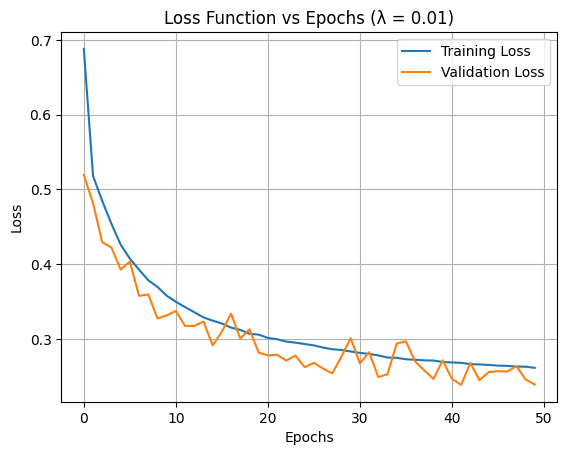

Final dev accuracy: 0.9551
Final dev error: 4.49 %


--- Best L2 Regularization Parameter ---
λ = 1e-05
Validation Accuracy: 98.07%
Validation Error: 1.93%


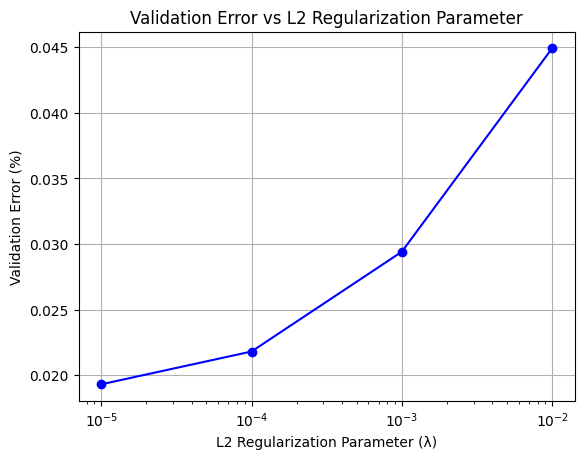

In [21]:
# Hyperparameters for 'best' (b)
lr_b = 0.0001
batch_b = 32
epoch_b = 50
units_b = 256
activation_b = 'tanh'
optimizer_b = 'rmsprop'

# Range of L2 regularization parameters to explore
l2_lambda_values = [1e-5, 1e-4, 1e-3, 1e-2]

# To store results
results = []

# Function to create and compile model with L2 regularization
def create_model(learning_rate, batch_size, hidden_units, activation, optimizer, l2_lambda):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hidden_units, 
                              activation=activation, 
                              input_shape=(28*28,),
                              kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),  # L2 regularization
        
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    # Compile model
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Perform search over L2 regularization strengths
for l2_lambda in l2_lambda_values:
    print(f"\nTraining with L2 regularization λ = {l2_lambda}")
    
    # Create model with current L2 regularization
    model = create_model(lr_b, batch_b, units_b, activation_b, optimizer_b, l2_lambda)
    
    # Train the model
    history = model.fit(x_train, y_train, 
                        epochs=epoch_b, 
                        batch_size=batch_b, 
                        validation_data=(x_test, y_test), 
                        verbose=0)
    
    # Evaluate final validation accuracy
    val_accuracy = history.history['val_accuracy'][-1]
    
    # Calculate dev error (1 - validation accuracy)
    dev_error = 1 - val_accuracy
    
    # Store results
    results.append({
        'l2_lambda': l2_lambda,
        'val_accuracy': val_accuracy,
        'dev_error': dev_error
    })
    
    # Plot loss curves
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Function vs Epochs (λ = {l2_lambda})')
    plt.legend()
    plt.grid()
    plt.show()
    
    print(f"Final dev accuracy: {val_accuracy:.4f}")
    print(f"Final dev error: {dev_error*100:.2f} %\n")

# Display the best L2 regularization parameter
results = sorted(results, key=lambda x: x['dev_error'])
print("\n--- Best L2 Regularization Parameter ---")
print(f"λ = {results[0]['l2_lambda']}")
print(f"Validation Accuracy: {results[0]['val_accuracy']*100:.2f}%")
print(f"Validation Error: {results[0]['dev_error']*100:.2f}%")

# Plot validation error vs L2 regularization parameter
plt.figure()
plt.plot([r['l2_lambda'] for r in results], [r['dev_error'] for r in results], marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.xlabel('L2 Regularization Parameter (λ)')
plt.ylabel('Validation Error (%)')
plt.title('Validation Error vs L2 Regularization Parameter')
plt.grid(True)
plt.show()